In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.skip import skip
from models import spatial
import torch
import torch.optim

from torch.autograd import Variable
from utils.inpainting_utils import *
from utils.common_utils import write_video

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

from IPython.display import HTML

PLOT = True

import skvideo.io
from skimage.transform import resize

In [3]:
T = 64
M = 10
N = 128

k = N
r = N

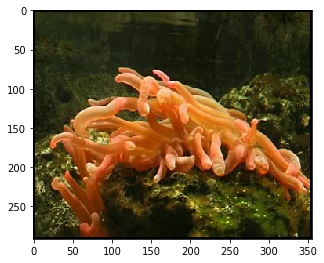

In [4]:
video_1 = skvideo.io.vread(fname='data/64ab310.avi')
plot_image_grid([np.transpose(video_1[0], axes=[2, 0, 1])], factor=4);

/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


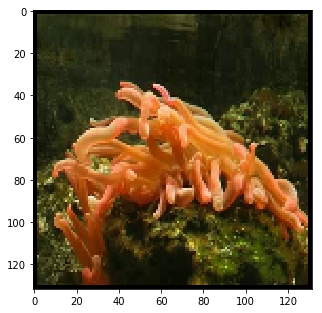

In [5]:
data = np.transpose(video_1[:64], [0, 3, 1, 2])
data = np.array(list(map(lambda x: resize(x, output_shape=(3, N, N)), data)))
plot_image_grid([data[0]], factor=4);

In [6]:
omega = np.exp(np.linspace(-3, 0, M))
mu = np.exp(np.linspace(-3, 0, M))

origin = np.random.normal(size=(1, k, r))
origin = torch.FloatTensor(origin)
origin = origin.cuda()
origin = Variable(origin, requires_grad=True)

z = Variable(torch.ones((T, 1, k, r)).cuda()) * origin
waves = np.ones((T, M, k, r)) * np.sin(np.outer(np.arange(T), omega) + mu)[:T, :M, None, None]
waves = torch.FloatTensor(waves)
waves = waves.cuda()
waves = Variable(waves)

net_input = torch.cat([z, waves], dim=1)

In [46]:
true_video = torch.FloatTensor(data)
true_video = true_video.cuda()
true_video = Variable(true_video)

In [47]:
LR = 0.01
OPT_OVER = 'net'
OPTIMIZER= 'adam' # 'LBFGS'
pad = 'reflection'
show_every = 499
reg_noise_std = 0
num_iter = 2000

input_depth = M + 1
figsize = 5

In [48]:
skip_params = {'num_input_channels': input_depth,
               'num_channels_down': [8, 16, 24, 32, 64],
               'num_channels_up': [8, 16, 24, 32, 64]}
net = spatial.Net(input_depth=input_depth, pic_size=N, skip_args=skip_params)
net = net.type(dtype)

In [49]:
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 440514


Starting optimization with ADAM


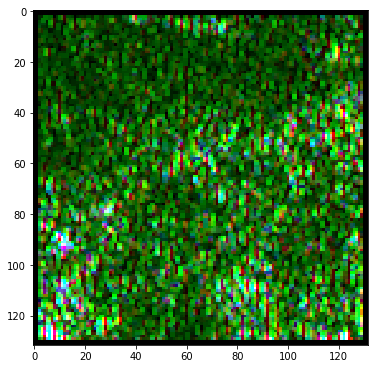

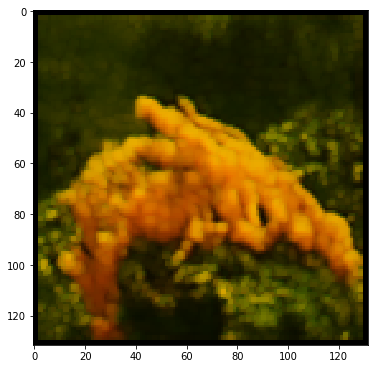

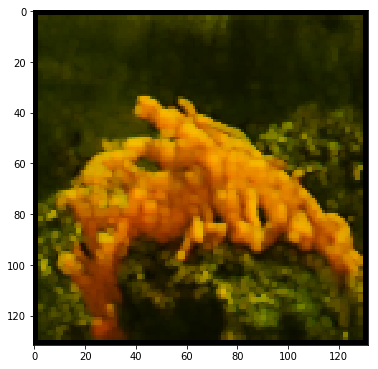

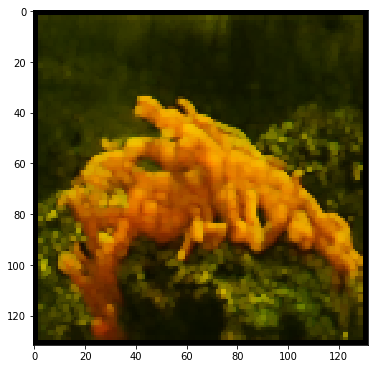

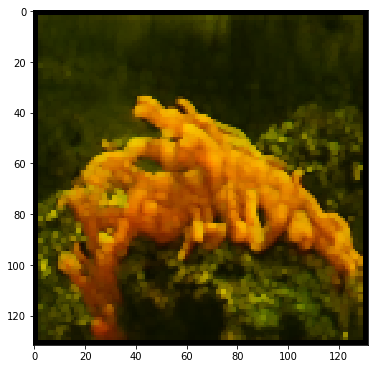

In [50]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

i = 0
def closure():
    
    global i
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
    
    z = Variable(torch.ones((T, 1, k, r)).cuda()) * origin
    net_input = torch.cat([z, waves], dim=1)
    out = net(net_input)
   
    total_loss = mse(out, true_video)
    total_loss.backward(retain_graph=True)
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = net(net_input)[0].cpu().data.numpy()
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
p += [origin]
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [62]:
delta_T = 128
data_pred = np.ones((delta_T, 1, k, r)) * z[0].cpu().data.numpy()
waves_pred = np.ones((delta_T, M, k, r)) * np.sin(np.outer(np.arange(delta_T), omega) + mu)[:, :, None, None]
initial_representation = np.concatenate([data_pred, waves_pred], axis = 1)
pred_input = torch.FloatTensor(initial_representation)
pred_input = pred_input.cuda()
pred_input = Variable(pred_input)

In [63]:
outputdata = np.clip(np.transpose(net(pred_input).cpu().data.numpy(), (0, 2, 3, 1)), 0, 1)           

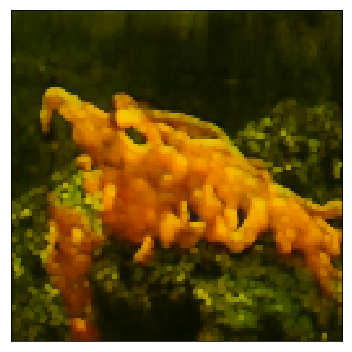

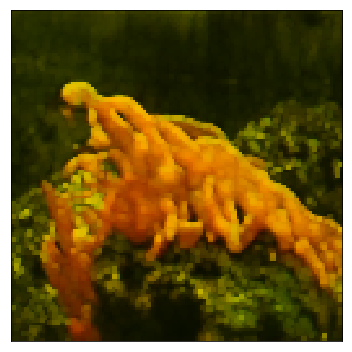

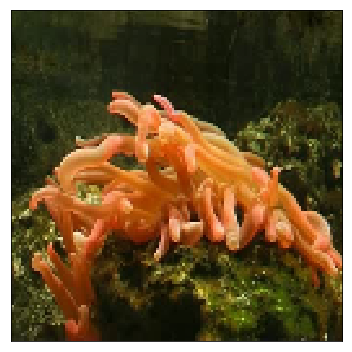

In [53]:
write_video("exp_6_fit_1.mp4", outputdata[:64])
write_video("exp_6_predict_1.mp4", outputdata[64:])
write_video("exp_6_original_1.mp4", np.transpose(data, (0, 2, 3, 1)));

In [54]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="exp_6_fit_1.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="exp_6_predict_1.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="exp_6_original_1.mp4" type="video/mp4">
</video>

In [55]:
net.eval();

In [56]:
outputdata = np.clip(np.transpose(net(pred_input).cpu().data.numpy(), (0, 2, 3, 1)), 0, 1)

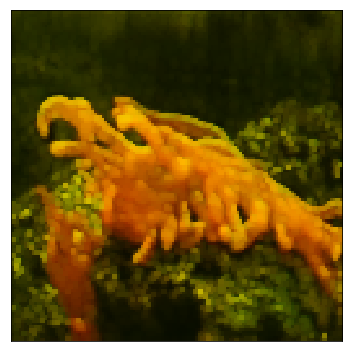

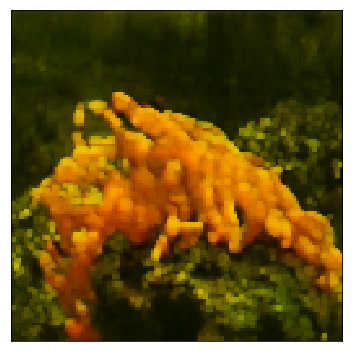

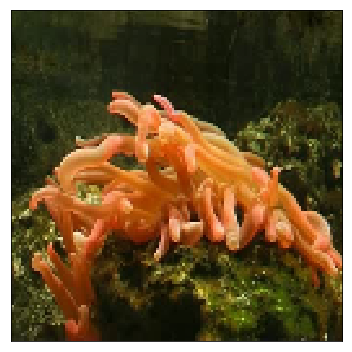

In [57]:
write_video("exp_6_fit_1_eval.mp4", outputdata[:64])
write_video("exp_6_predict_1_eval.mp4", outputdata[64:])
write_video("exp_6_original_1_eval.mp4", np.transpose(data, (0, 2, 3, 1)));

In [58]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="exp_6_fit_1_eval.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="exp_6_predict_1_eval.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="exp_6_original_1_eval.mp4" type="video/mp4">
</video>